In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
# 加载数据
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']



In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class DSU(Layer):
    def __init__(self, output_dim, **kwargs):
        super(DSU, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        # 创建一个权重矩阵，用于将稀疏输入转换为密集表示
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(DSU, self).build(input_shape)

    def call(self, inputs):
        # 假设输入是一个稀疏矩阵
        # 使用权重矩阵对输入进行转换
        dense_output = tf.matmul(inputs, self.kernel)
        return dense_output

    def compute_output_shape(self, input_shape):
        # 输出形状为(batch_size, output_dim)
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = super(DSU, self).get_config()
        config.update({
            'output_dim': self.output_dim
        })
        return config

In [6]:
from tensorflow.keras.layers import Input, Conv1D, LayerNormalization, Activation, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu
import tensorflow as tf
def convnext_block_1d(x, filters, kernel_size, strides):
    shortcut = x
    # 主卷积路径
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(gelu)(x)
    x = Conv1D(filters, 7, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(gelu)(x)
    x = Conv1D(filters, 3,padding='same')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != x.shape[-1] or shortcut.shape[-2] != x.shape[-2]:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # 添加跳过连接
    x = Add()([x, shortcut])
    x = Activation(gelu)(x)
    return x
def convnext_1d(num_classes=4):
    input_1 = Input(shape=(4500, 1))
    x = Conv1D(32, 31, strides=2, padding='same')(input_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Stacking ConvNeXt blocks for 1D with more layers and GELU activation
    x = convnext_block_1d(x, 32, 31, 2)  # (3000, 32)
    x = convnext_block_1d(x, 64, 17, 2)  # (1500, 64)
    x = convnext_block_1d(x, 128, 9, 2)  # (750, 128)
    x = convnext_block_1d(x, 128, 9, 1)  # Added an additional block with no stride change
    x = convnext_block_1d(x, 256, 5, 2)  # (375, 256)
    # Global Average Pooling as in typical ConvNeXt architectures, but for 1D
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)  # GELU activation in dense layer
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_1, outputs=x)
    return model
model = convnext_1d()

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 32)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 32)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=256, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
55/55 [==============================] - 25s 165ms/step - loss: 0.3219 - accuracy: 0.7013 - val_loss: 0.3518 - val_accuracy: 0.6567
Epoch 2/80
55/55 [==============================] - 8s 140ms/step - loss: 0.2431 - accuracy: 0.7914 - val_loss: 0.6629 - val_accuracy: 0.3989
Epoch 3/80
55/55 [==============================] - 8s 140ms/step - loss: 0.2199 - accuracy: 0.8170 - val_loss: 0.2598 - val_accuracy: 0.7842
Epoch 4/80
55/55 [==============================] - 8s 140ms/step - loss: 0.2016 - accuracy: 0.8365 - val_loss: 0.2776 - val_accuracy: 0.7689
Epoch 5/80
55/55 [==============================] - 8s 141ms/step - loss: 0.1962 - accuracy: 0.8428 - val_loss: 0.3681 - val_accuracy: 0.7134
Reduced learning rate to 0.00010000000474974513.
Epoch 6/80
55/55 [==============================] - 8s 141ms/step - loss: 0.1698 - accuracy: 0.8669 - val_loss: 0.2007 - val_accuracy: 0.8425
Epoch 7/80
55/55 [==============================] - 8s 142ms/step - loss: 0.1598 - accuracy: 0.878

In [8]:
evaluate_model(model,X_test,y_test)

Precision: 0.8101726296494344
Recall: 0.7875441491822726
F1 Score: 0.7977728296191913
Accuracy: 0.8829444891391794
Class 1 - Precision: 0.8782608695652174, Recall: 0.8898678414096917, F1 Score: 0.8840262582056894
Class 2 - Precision: 0.9001907183725365, Recall: 0.9433710859427049, F1 Score: 0.9212752114508783
Class 3 - Precision: 0.8511278195488722, Recall: 0.7669376693766937, F1 Score: 0.8068424803991447
Class 4 - Precision: 0.6111111111111112, Recall: 0.55, F1 Score: 0.5789473684210527
Class 1 Accuracy: 0.9786806114239742
Class 2 Accuracy: 0.9026548672566371
Class 3 Accuracy: 0.8909895414320194
Class 4 Accuracy: 0.9935639581657281


In [9]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

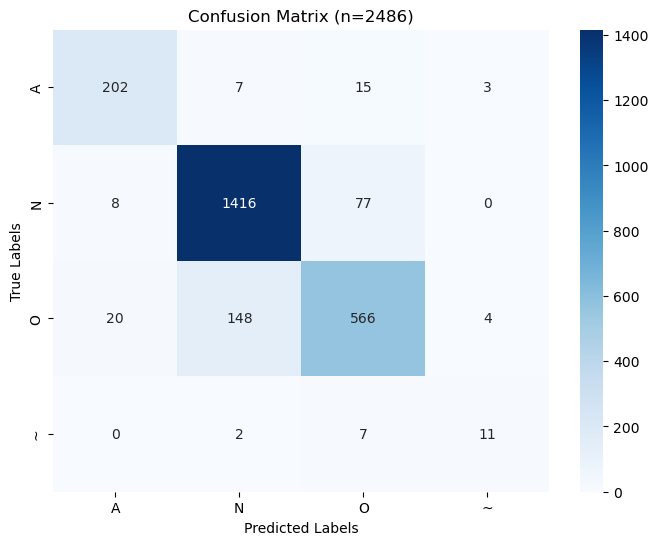

In [10]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])